In [1]:
%matplotlib inline

In [66]:
import numpy as np
import scipy.integrate as integrate
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from mpl_toolkits import mplot3d
import random as random
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

In [3]:
class Robot():
    
    #Class for the robot with lengths of links and the axis defined as they would be in the defalt zero position
    
    def __init__(self, links = [.25,1,1,.75], axis = [[0,0,1],[0,1,0],[0,1,0],[0,1,0]]):
        self.links = links
        self.axis = axis
        
    def rotateAxis(self, t, vec):
        
        #Rotation matrix just taken straight from wikepedia
        
        C = 1-np.cos(t);
        x,y,z = vec;

        Rot = [[x**2*C+np.cos(t), x*y*C-z*np.sin(t), z*x*C+y*np.sin(t)],
                [x*y*C+z*np.sin(t), y**2*C+np.cos(t), z*y*C-x*np.sin(t)],
                [x*z*C-y*np. sin(t), y*z*C+x*np.sin(t), z**2*C+np.cos(t)]]

        return Rot

    def findEnd(self, angles):
        #This function takes an input vector of angles and will output the end position as
        #well as all of the vectors of the robot NOT TRANSLATED FROM THE ORIGIN
        
        v1 = [0,0,0]
        v2 = [0,0,0]
        v3 = [0,0,0]
        v4 = [0,0,0]
        
        #Starting Vector
        v1_0 = [self.links[0]/np.sqrt(2),0,self.links[0]/np.sqrt(2)];
        
        #First rotation
        v1 = np.dot(v1_0,self.rotateAxis(angles[0], self.axis[0]));
        axis1 = np.dot(self.axis[1],self.rotateAxis(angles[0], self.axis[0]));
        axis2 = np.dot(self.axis[2],self.rotateAxis(angles[0], self.axis[0]));
        axis3 = np.dot(self.axis[3],self.rotateAxis(angles[0], self.axis[0]));

        #Second Rotation
        v2 = (self.links[1]/self.links[0])*np.dot(v1,self.rotateAxis(angles[1], axis1));
        axis2 = np.dot(axis2,self.rotateAxis(angles[1], axis1));
        axis3 = np.dot(axis3,self.rotateAxis(angles[1], axis1));

        #Third Rotation
        v3 = (self.links[2]/self.links[1])*np.dot(v2,self.rotateAxis(angles[2], axis2));
        axis3 = np.dot(axis3,self.rotateAxis(angles[2], axis2));

        #Fourth rotation
        axis3 = np.dot(axis3,self.rotateAxis(angles[3], v3));

        #Fifth Rotation
        v4 = (self.links[3]/self.links[2])*np.dot(v3,self.rotateAxis(angles[4], axis3));
        
        x_val = v1[0]+v2[0]+v3[0]+v4[0]
        y_val = v1[1]+v2[1]+v3[1]+v4[1]
        z_val = v1[2]+v2[2]+v3[2]+v4[2]
        
        return [x_val, y_val, z_val, v1, v2, v3, v4]
    
    def distanceFromTarget(self,targ,angles):
        
        #Simply finds the distance between a given end from a set of angles and a target end point
        
        end = self.findEnd(angles)
        dist = (end[0]-targ[0])**2+(end[1]-targ[1])**2+(end[2]-targ[2])**2
        
        return dist
    



In [4]:
def drawRobot(v1,v2,v3,v4):
    
    #I guess the name of this function is deceptive but it takes the vectors and translates them essentially
    
    x = np.zeros(100,)
    y = np.zeros(100,)
    z = np.zeros(100,)

    # This is an admittedly weird way to do this, but it is what it is.
    # The process is like walking along in the direction of vectors 1-4 until you reach the end
    # The magnitude of the links are arbitrary but the relative size is still normal as defined
    
    for i in range(100):
        if i <= 24:
            x[i] = i*v1[0]
            y[i] = i*v1[1]
            z[i] = i*v1[2]
        elif i > 24 and i<=49:
            x[i] = 24*v1[0] + (i-24)*v2[0]
            y[i] = 24*v1[1] + (i-24)*v2[1]
            z[i] = 24*v1[2] + (i-24)*v2[2]
        elif i > 49 and i<=74:
            x[i] = 24*v1[0] + 25*v2[0]+ (i-49)*v3[0]
            y[i] = 24*v1[1] + 25*v2[1]+ (i-49)*v3[1]
            z[i] = 24*v1[2] + 25*v2[2]+ (i-49)*v3[2]
        else:
            x[i] = 24*v1[0] + 25*v2[0] + 25*v3[0] + (i-74)*v4[0]
            y[i] = 24*v1[1] + 25*v2[1] + 25*v3[1] + (i-74)*v4[1]
            z[i] = 24*v1[2] + 25*v2[2] + 25*v3[2] + (i-74)*v4[2]

    
    return x,y,z

[1.3624368670764586, 0.30177669529663653, 1.176776695296637]


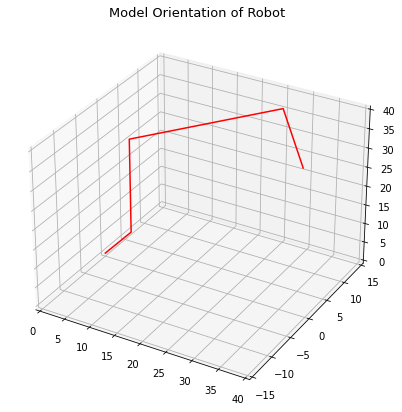

In [12]:
#Defining a instance of the robot
links = [.25,1,1,.75]
axis = [[0,0,1],[0,1,0],[0,1,0],[0,1,0]]
anglesDesired = [np.pi/4,0,0,np.pi/2,np.pi/2]

#Changing from normal physics conventions of angle definition to the way the robot defines them:
anglesConvention = [-1*anglesDesired[0],(np.pi/4-anglesDesired[1]),\
                    (-np.pi/2+anglesDesired[2]),anglesDesired[3],-1*anglesDesired[4]]

Moto = Robot(links = links, axis = axis)
End = Moto.findEnd(anglesConvention)
print([End[0],End[1],End[2]])

#Show on a 3D plot

v1,v2,v3,v4 = End[3],End[4],End[5],End[6]

x,y,z = drawRobot(v1,v2,v3,v4)
             
#print(x)
#print(y)
#print(z) 


# creating an empty canvas
fig = plt.figure(figsize = (7,7))

# defining the axes with the projection
# as 3D so as to plot 3D graphs
ax = plt.axes(projection="3d")
ax.set_xlim(0,40)
ax.set_ylim(-15,15)
ax.set_zlim(0,40)

# plotting a 3D line graph with X-coordinate,
# Y-coordinate and Z-coordinate respectively
ax.plot3D(x,y,z, 'red')


 
# Showing the above plot
plt.title('Model Orientation of Robot',fontsize=13)
plt.show()

In [13]:
#Try some hill climbing
anglesDesired = [np.pi/4,0,0,np.pi/2,np.pi/2]
anglesConvention = [-1*anglesDesired[0],(np.pi/4-anglesDesired[1]),\
                    (-np.pi/2+anglesDesired[2]),anglesDesired[3],-1*anglesDesired[4]]
Moto = Robot(links = links, axis = axis)
End = Moto.findEnd(anglesConvention)
print(End)
Target = [End[0],End[1],End[2]]

angles_start = np.array([anglesConvention[0]-.25,anglesConvention[1]+.25,\
                   anglesConvention[2]-.25,anglesConvention[3]+.25,anglesConvention[4]-.25])
angles = np.array([anglesConvention[0]-.25,anglesConvention[1]+.25,\
                   anglesConvention[2]-.25,anglesConvention[3]+.25,anglesConvention[4]-.25])

#Step size for the hill searching
step = .1

    
dist = Moto.distanceFromTarget(Target,angles)   


for i in range(1000): #Hill climb starts
    
    #print(angles)
    dist = Moto.distanceFromTarget(Target,angles) #Try something
    #print(dist)
    
    #look somewhere else
    angles_test = [angles[0]+step*random.uniform(-1,1),angles[1]+step*random.uniform(-1,1),\
                   angles[2]+step*random.uniform(-1,1),angles[3]+step*random.uniform(-1,1),angles[4]+step*random.uniform(-1,1)]
    #print(angles_test)
    dist_test = Moto.distanceFromTarget(Target,angles_test) #try that
    
    #What it better?
    if dist_test<=dist:
        angles = angles_test;
        print('Angles Changed')
    else:
        continue
        
#print(angles)

[1.3624368670764586, 0.30177669529663653, 1.176776695296637, array([0.125    , 0.125    , 0.1767767]), array([-2.29934717e-17, -2.29934717e-17,  1.00000000e+00]), array([7.07106781e-01, 7.07106781e-01, 9.37500195e-17]), array([ 5.30330086e-01, -5.30330086e-01, -1.03830841e-16])]
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed
Angles Changed


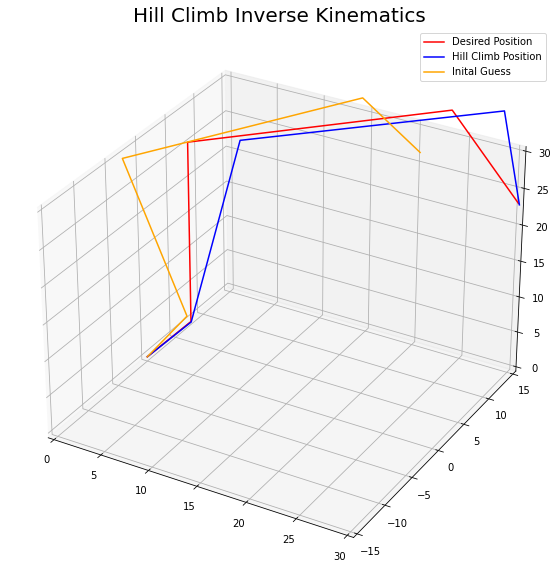

In [62]:
#Print everything on top of each other to see how good the hill climb is
Moto_hc = Robot(links = links, axis = axis)
End_hc = Moto_hc.findEnd(angles)
End_0 = Moto.findEnd(angles_start)

v1_hc,v2_hc,v3_hc,v4_hc = End_hc[3],End_hc[4],End_hc[5],End_hc[6]
x_hc,y_hc,z_hc = drawRobot(v1_hc,v2_hc,v3_hc,v4_hc)

v1_0, v2_0, v3_0, v4_0 = End_0[3],End_0[4],End_0[5],End_0[6]
x_0,y_0,z_0 = drawRobot(v1_0,v2_0,v3_0,v4_0)

#Desired Robot:
End_desired = Moto.findEnd(anglesConvention)
#print(x)
#print(y)
#print(z) 


# creating an empty canvas
fig2 = plt.figure(figsize = (10,10))
 
# defining the axes with the projection
# as 3D so as to plot 3D graphs
ax2 = plt.axes(projection="3d")
ax2.set_xlim(0,30)
ax2.set_ylim(-15,15)
ax2.set_zlim(0,30)
# plotting a 3D line graph with X-coordinate,
# Y-coordinate and Z-coordinate respectively
ax2.plot3D(x,y,z,'red')
ax2.plot3D(x_hc,y_hc,z_hc,'blue')
ax2.plot3D(x_0,y_0,z_0,'orange')
ax2.legend(['Desired Position','Hill Climb Position','Inital Guess'])

 
# Showing the above plot
plt.title('Hill Climb Inverse Kinematics',fontsize=20)
plt.show()


In [120]:
def Gauss(t_pts, sigma, mean, amp ):
    f = np.zeros(len(t_pts))
    for i in range(len(t_pts)):
        f[i] = amp*np.exp(-(t_pts[i]-mean)**2/(2*sigma**2))
    
    return f

In [121]:
def num_integrate(vel,t_pts):
    area = 0
    delta_x = t_pts[1]-t_pts[0]
    theta = np.zeros(len(vel))
    
    for i in range(len(vel)):
        area = area + vel[i]*delta_x
        theta[i] = area
        
    return theta 

In [122]:
def find_amp(sigma,delta_theta):
    amp = delta_theta/(sigma*np.sqrt(2*np.pi))
    return amp

1000


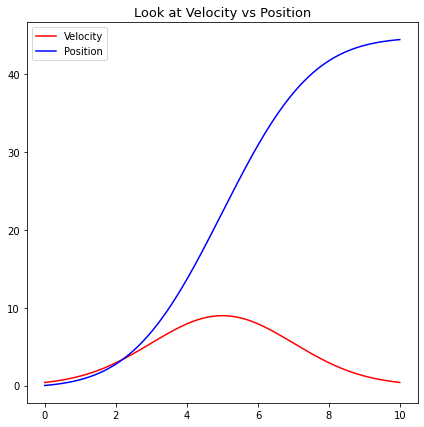

In [136]:
t_pts = np.arange(0,10,.01)
print(len(t_pts))
delta_theta = 45
sigma = 2
mean = 5
amp = find_amp(sigma, delta_theta)
vel = Gauss(t_pts,sigma,mean,amp)
theta = num_integrate(vel,t_pts)

# creating an empty canvas
fig_test = plt.figure(figsize = (7,7))

# defining the axis
ax_test = fig_test.add_subplot(1,1,1)

#Plotting the velocity and positions on each other
ax_test.plot(t_pts,vel,'red')
ax_test.plot(t_pts,theta,'blue')
# Showing the above plot
plt.title('Look at Velocity vs Position',fontsize=13)
plt.legend(['Velocity','Position'])
plt.show()

100
3.141592653589793


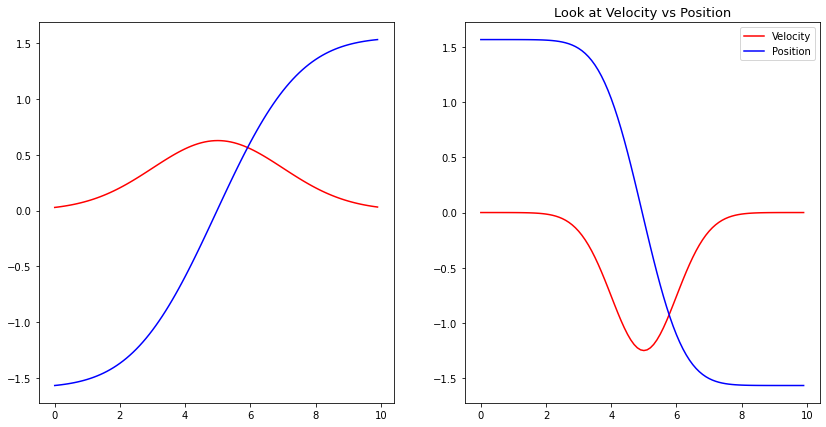

100


'\n#B = np.arange(B_start, B_end,B_delta_t); #J-Move\n\n#Faster Move\nfirst = np.ones(40)*B_start;\nlast = np.ones(40)*B_end;\ninside = np.arange(B_start,B_end,B_delta_t_fast);\nB= np.append(first,np.append(inside,last)); \n'

In [160]:
# THIS IS the S FUNCTION PART

S_start = -np.pi/2;
S_end = np.pi/2;
S_delta_t = (S_end-S_start)
B_start = np.pi/2;
B_end = -np.pi/2;
B_delta_t = (B_end-B_start)*-1;                                                                          
B_delta_t_fast = (B_end-B_start)/20;

t_pts = np.arange(0,10,.1)
print(len(t_pts))
sigma_s = 2
mean_s = 5
amp_s = find_amp(sigma_s, S_delta_t)
vel_s = Gauss(t_pts,sigma_s,mean_s,amp_s)
S = S_start + num_integrate(vel_s,t_pts)

sigma_b = 1
mean_b = 5
amp_b = find_amp(sigma_b, B_delta_t)
vel_b = -1*Gauss(t_pts,sigma_b,mean_b,amp_b);
B = B_start + num_integrate(vel_b,t_pts)

print(B_delta_t)
L = np.ones(100)*np.pi/24;
U = np.ones(100)*-np.pi/4;
R = np.ones(100)*np.pi/2;

#Plot the interesting ones
# creating an empty canvas
fig2= plt.figure(figsize = (14,7))

# defining the axis
ax_S = fig2.add_subplot(1,2,1)
ax_B = fig2.add_subplot(1,2,2)
#Plotting the velocity and positions on each other
ax_S.plot(t_pts,vel_s,'red')
ax_S.plot(t_pts,S,'blue')
ax_B.plot(t_pts,vel_b,'red')
ax_B.plot(t_pts,B,'blue')
# Showing the above plot
plt.title('Look at Velocity vs Position',fontsize=13)
plt.legend(['Velocity','Position'])
plt.show()

print(len(B))

"""
#B = np.arange(B_start, B_end,B_delta_t); #J-Move

#Faster Move
first = np.ones(40)*B_start;
last = np.ones(40)*B_end;
inside = np.arange(B_start,B_end,B_delta_t_fast);
B= np.append(first,np.append(inside,last)); 
"""

0.0
-0.0
0.0


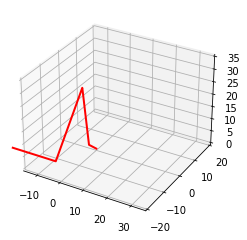

In [161]:
#Animation setup

fig_anim = plt.figure(figsize=(4,4))
ax_anim = plt.axes(projection = "3d")
ax_anim.set_xlim(-15,35)
ax_anim.set_ylim(-20,20)
ax_anim.set_zlim(0,35)

#Defining a instance of the robot
links = [.25,1,1,.75]
axis = [[0,0,1],[0,1,0],[0,1,0],[0,1,0]]
MotoAnimate = Robot(links = links, axis = axis)




anglesDesired_anim = [S[0],L[0],U[0],R[0],B[0]];
#Changing from normal physics conventions of angle definition to the way the robot defines them:
anglesConvention_anim = [-1*anglesDesired_anim[0],(np.pi/4-anglesDesired_anim[1]),\
                    (-np.pi/2+anglesDesired_anim[2]),anglesDesired_anim[3],-1*anglesDesired_anim[4]]

End_anim = Moto.findEnd(anglesConvention_anim)
#print([End[0],End[1],End[2]])

v1_anim,v2_anim,v3_anim,v4_anim = End_anim[3],End_anim[4],End_anim[5],End_anim[6]

x_anim,y_anim,z_anim = drawRobot(v1_anim,v2_anim,v3_anim,v4_anim)
line_anim, = ax_anim.plot(x_anim,y_anim,z_anim,'red',lw =2)

print(x_anim[0])
print(y_anim[0])
print(z_anim[0])

In [162]:
#Maybe we can animate a swing??? 


             

def animate_swing(i):
    
    anglesDesired_anim = [S[i],L[i],U[i],R[i],B[i]];
    #Changing from normal physics conventions of angle definition to the way the robot defines them:
    anglesConvention_anim = [-1*anglesDesired_anim[0],(np.pi/4-anglesDesired_anim[1]),\
                        (-np.pi/2+anglesDesired_anim[2]),anglesDesired_anim[3],-1*anglesDesired_anim[4]]

    End_anim = Moto.findEnd(anglesConvention_anim)
    #print([End[0],End[1],End[2]])

    v1_anim,v2_anim,v3_anim,v4_anim = End_anim[3],End_anim[4],End_anim[5],End_anim[6]


    x_anim,y_anim,z_anim = drawRobot(v1_anim,v2_anim,v3_anim,v4_anim)
    line_anim.set_xdata(x_anim)
    line_anim.set_ydata(y_anim)
    line_anim.set_3d_properties(z_anim)
    return(line_anim,)

In [163]:
frame_interval = 20.  # time between frames
frame_number = 100    # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_swing, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=True)


In [164]:
HTML(anim.to_jshtml())